# Calculation of an IR Spectrum

This tutorial demonstrates the calculation of an IR spectrum using the ORCA python interface (OPI).

In this notebook we will:
1.  Import the required Python dependencies
2.  Define a working directory
3.  Set up an input structure for our calculation
4.  Perform a frequency calculation in the gas-phase
5.  Parse the results and plot it

## Step 1: Import Dependencies

We start by importing the modules needed for:
- Interfacing with ORCA input/output
- Numerical calculations and data handling
- Plotting results

> **Note:** We additionally import modules for visualization/plotting like `py3Dmol`. For this, it might be necessary to install `py3Dmol` into your OPI `venv` (e.g., by activating the `.venv` and using `uv pip install py3Dmol`).

In [1]:
# > Import pathlib for directory handling
from pathlib import Path
import shutil

# > Import numpy for data handling and numerical operations
import numpy as np

# > OPI imports for performing ORCA calculations and reading output
from opi.core import Calculator
from opi.input.simple_keywords import Dft, Task, BasisSet, Approximation, AuxBasisSet, DispersionCorrection
from opi.input.structures.structure import Structure
from opi.input.blocks.block_freq import BlockFreq

# > Import libraries for visualization
import matplotlib.pyplot as plt
import py3Dmol

## Step 2: Define Working Directory

All actual calculations will be performed in a subfolder **RUN_09**.

In [ ]:
# > Calculation is performed in `RUN`
working_dir = Path("RUN")
# > The `working_dir`is automatically (re-)created
shutil.rmtree(working_dir, ignore_errors=True)
working_dir.mkdir()

## Step 3: Setup an Input Structure

We use **methanol** as our example molecule. The 3D structure in Cartesian coordinates is defined in XYZ format and visualized.


In [3]:
# > Define the molecule's Cartesian coordinates in Angstroem as python string 
xyz_data = """\
7

O            1.14430000000000        0.24120000000000        0.00000000000000
C           -1.25740000000000        0.18150000000000        0.00000000000000
C            0.11300000000000       -0.42260000000000        0.00000000000000
H           -1.79380000000000       -0.14930000000000        0.89240000000000
H           -1.18650000000000        1.27190000000000        0.00160000000000
H           -1.79280000000000       -0.14680000000000       -0.89380000000000
H            0.14780000000000       -1.52520000000000       -0.00070000000000\n
"""

# > Visualize the molecular structure using py3Dmol
view = py3Dmol.view(width=500, height=500)
view.addModel(xyz_data, "xyz")
view.setStyle({'stick': {'radius': 0.1}, 'sphere': {'scale': 0.2}})
view.setBackgroundColor('white')
view.zoomTo()
view.show()

# > Save the XYZ structure to a file
with open(working_dir / "struc.xyz","w") as f:
    f.write(xyz_data)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 4: Calculation in the Gas-Phase


We run a geometry optimization and frequency calculation

In [4]:
# > Set up path and create directory for implicit model calculation
xyz_file = working_dir / "struc.xyz"

# > Create a Calculator object for ORCA input generation and execution
calc = Calculator(basename="gas", working_dir=working_dir)

# > Load the molecular structure from XYZ file
structure = Structure.from_xyz(xyz_file)
calc.structure = structure
calc.structure.charge = 0
calc.structure.multiplicity = 1

# > Add calculation keywords
calc.input.add_simple_keywords(
    Dft.B3LYP, # > B3LYP method
    BasisSet.AUG_CC_PVDZ, # > daug-cc-pVDZ basis set
    AuxBasisSet.DEF2_J, # > auxiliary basis set
    Approximation.RIJCOSX, # > Use RIJ and COSX
    DispersionCorrection.D4, # > Use D4 model
    Task.FREQ # > Do analytical Hessian
)

calc.input.add_blocks(
    BlockFreq(scalfreq=0.970) # > Optimal scaling factor for B3LYP/aug-cc-pVDZ
)

# > Write the ORCA input file
calc.write_input()
# > Run the ORCA calculation
print("Running ORCA frequency calculation ...", end="")
calc.run()
print("   Done")

Running ORCA frequency calculation ...   Done


## Step 5: Parse Vibrational Spectrum and Plot it

We define a function for extracting the vibrational spectrum from the ORCA and plot it.

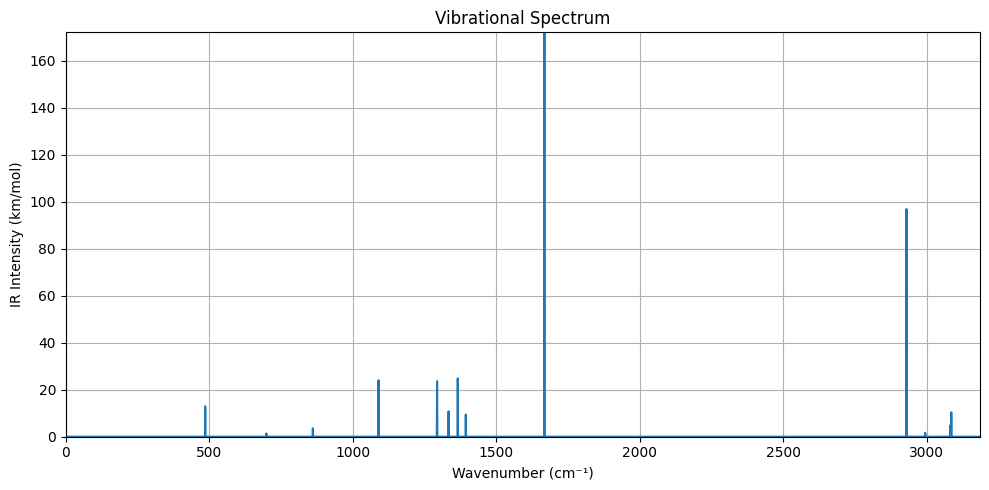

In [5]:
def plot_vibrational_spectrum(vibrational_spectrum: Path) -> None:
    wave_numbers = []
    intensities = []

    # > While frequencies are available in OPI,
    # > intensities are currently not.
    # > Therefore, we grep them manually.
    with open(vibrational_spectrum) as f:
        in_block = False
        for line in f:
            if not in_block and "IR SPECTRUM" in line:
                in_block = True
                for _ in range(5):
                    next(f)
            elif in_block and not line.strip():  # end of block
                break
            elif in_block:
                parts = line.split()
                try:
                    wave_number = float(parts[1])
                    intensity = float(parts[3])
                    if wave_number > 0 and intensity > 0:
                        wave_numbers.append(wave_number)
                        intensities.append(intensity)
                except ValueError:
                    continue

    # > Generate IR spectrum by creating a zero baseline and populating intensity values
    max_wave = int(max(wave_numbers)) + 100
    full_range = np.arange(0, max_wave, 1)
    spectrum = np.zeros_like(full_range, dtype=float)

    for wn, inten in zip(wave_numbers, intensities):
        index = int(wn)
        if index < len(spectrum):
            spectrum[index] = inten

    # > Plot the vibrational IR spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(full_range, spectrum)
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('IR Intensity (km/mol)')
    plt.title('Vibrational Spectrum')
    plt.grid(True)
    plt.xlim(0, max_wave)
    plt.ylim(0, max(intensities))
    plt.tight_layout()
    plt.show()

# > Plot vibrational spectrum for implicit solvation result
spectrum_path = working_dir / "gas.out"
plot_vibrational_spectrum(spectrum_path)

## Summary

In this notebook we demonstrated how the ORCA Python interface can be employed to calculate the frequencies and intensities required for predicting an IR spectrum.